### Functions

#### Input dtm as np.matrix, returns scaled DTM as pd.DataFrame

Because we have outliers in the data, we scaled the input as with sklearn.preprocessing, scale (http://www.dataminingblog.com/standardization-vs-normalization/)
Scaled data to have zero mean and a variance of one

In [1]:
import numpy as np
import pandas as pd
import pickle

def sourceInput(filePath):
    data_np = np.load(filePath)
    data_df = pd.DataFrame(data_np)
    #data_scaled_np = scale(data_df)
    #data_scaled_df = pd.DataFrame(data_scaled_np)
    
    return(data_np, data_df)

#### Generate k-means clusters
#### Find centroids for k-means clusters
#### Calculate metrics of cluster evaluation based on Euclidean distance:

- **Within Cluster Sum of Squares**, `WCSS`:
    - The total distance of data points from their respective cluster centroids

- **Average Within Cluster Sum of Squares**, `AWSS`:
    - The average distance of data points from their respective cluster centroids

- **Between Cluster Sum of Squares**, `BSS`:
    - The total distance of various cluster centroids to the global mean of data

- **Total Sum of Squares**, `TSS`:
    - The total distance of data points from global mean of data, for a given dataset tss is going to be constant

-  **(= BSS/TSS)**, `Rsq`:
    - The total variance explained by clustering

*We expect WCSS to be lower and BSS to be higher, thus we should select the iteration with maximum BSS/TSS*

In [2]:
from sklearn.cluster import KMeans

def generateClusters(k_range, data_df):

    def gen_kmeans_clusters(k_range, data_df):
        clusters = [KMeans(n_clusters=k, random_state=10).fit(data_df) for k in k_range]       
        return(clusters)
    
    def gen_centroids(clusters):
        centroids=[X.cluster_centers_ for X in clusters]
        return(centroids)
    
    def genMetrics(input_data, centroids):
    
        D_k = [cdist(input_data, cent, 'euclidean') for cent in centroids]
        # returns the smallest euclidean distance between clusters
        dist = [np.min(D,axis=1) for D in D_k]

        metrics = {}
    
        AWSS = [sum(d)/input_data.shape[0] for d in dist]
        metrics['AWSS'] = AWSS
    
        WCSS = [sum(d**2) for d in dist]
        metrics['WCSS'] = WCSS
    
        TSS = sum(pdist(input_data)**2)/input_data.shape[0]
        metrics['TSS'] = TSS
    
        BSS = TSS - WCSS
        metrics['BSS'] = BSS
    
        RSQ = (BSS/TSS)
        metrics['RSQ'] = RSQ*100
    
        return(metrics)
    
    data_clusters = gen_kmeans_clusters(k_range, data_df)
    data_centroids = gen_centroids(data_clusters)
    data_metrics = genMetrics(data_df, data_centroids)

    return (data_clusters, data_centroids, data_metrics)

#### Graph the various cluster metric vs the number of cluster k

In [3]:
from sklearn.externals import joblib
from sklearn.metrics import *
from sklearn.preprocessing import *
from numpy import random
from scipy.spatial.distance import *
from matplotlib import pyplot as plt
from __future__ import print_function
import matplotlib.cm as cm
import time
%matplotlib inline


def graphing(k_range, metricName, metrics):
  
    y_label = None
    title = None
    if metricName == 'AWSS':
        y_label = 'Average within-cluster sum of squares'
        title = 'Elbow for KMeans clustering' 
    elif metricName == 'RSQ':
        y_label = 'Percentage of variance explained'
        title = 'Variance Explained vs k'
    
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    ax.plot(k_range, metrics[metricName], 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel(y_label)
    plt.title(title)

#### Graph the silhouette coefficient vs the number of cluster k

In [4]:
def silhouetteGraph(data_df, clusters):
    s=[silhouette_score(data_df, X.labels_, metric='euclidean', random_state=10) for X in clusters]   
    plt.plot(s)
    plt.grid(True)
    plt.ylabel("Silhouette")
    plt.xlabel("k")
    plt.title("Silhouette Score vs K")

#### Silhouette plot
This plot shows sorted silhouette coefficients for each point in a cluster, grouped by cluster.

In [5]:
def silhouetteAnalysis(data_np, range_n_clusters):    
    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 1 columns
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(10, 7)
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data_np) + (n_clusters + 1) * 10])
        #ax1.set_xlim([-0.3,0.4])
        # Initialize clusters
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data_np)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data_np, cluster_labels)
        print("For n_clusters =", n_clusters,
                "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data_np, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                0, ith_cluster_silhouette_values,
                                facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                        "with n_clusters = %d" % n_clusters),
                        fontsize=14, fontweight='bold')

        plt.show()

# Investigation

In [6]:
# save_load_path = '/home/eolus/Dropbox/MA755 Public/pynotes/Danny-Eole-Yuchen/Pickles'
save_load_path = '/Users/YuchenZhou/Dropbox (Personal)/MA755 Public/pynotes/Danny-Eole-Yuchen/Pickles'
# save_load_path = '/Users/Dannyhsiao/Dropbox/MA755 Public (1)/pynotes/Danny-Eole-Yuchen/Pickles'

## Data sources

In [7]:
# Binary weighted DTM
binary_data_np, binary_data_df = sourceInput(save_load_path+'/DTM/binary_matrix.npy')

# Tf-Idf weighted DTM
tfidf_data_np, tfidf_data_df = sourceInput(save_load_path+'/DTM/tfidf_matrix.npy')

# Tf weighted DTM
tf_data_np, tf_data_df = sourceInput(save_load_path+'/DTM/tf_matrix.npy')

### Choose range of number of clusters to try out

Run cluster analysis, with the number of cluster ranging from 10 to 70

In [11]:
k_range=range(5,20)

### Generate clusters

#### Binary weighting

In [12]:
binary_data_clusters, binary_data_centroids, binary_data_metrics = generateClusters(k_range, binary_data_df)

#### Tf-idf weighting

In [13]:
tfidf_data_clusters, tfidf_data_centroids, tfidf_data_metrics = generateClusters(k_range, tfidf_data_df)

#### Term frequency

In [14]:
tf_data_clusters, tf_data_centroids, tf_data_metrics = generateClusters(k_range, tf_data_df)

### Save data

In [15]:
def saveData(file_name, clusters, centroids, metrics, save_load_path = save_load_path):
    
    cluster_data = {}
    cluster_data['data_clusters'] = clusters
    cluster_data['data_centroids'] = centroids
    cluster_data['data_metrics'] = metrics
    
    full_path = "{save_load_path}/Clustering/Data output/Cluster_Z/{file_name}.pkl".\
    format(save_load_path=save_load_path, file_name=file_name)
    
    pickle.dump( cluster_data, \
               open (full_path, "wb"))

In [16]:
saveData('binary_cluster_data', binary_data_clusters, binary_data_centroids, binary_data_metrics, save_load_path)

In [17]:
saveData('tfidf_cluster_data', tfidf_data_clusters, tfidf_data_centroids, tfidf_data_metrics, save_load_path)

In [18]:
saveData('tf_cluster_data', tf_data_clusters, tf_data_centroids, tf_data_metrics, save_load_path)

## Graphical analysis of the clustering results

In [19]:
binary_cluster_data = pickle.load(open( save_load_path+"/Clustering/Data output/Cluster_Z/binary_cluster_data.pkl", "rb" ) )
tfidf_cluster_data = pickle.load(open( save_load_path+"/Clustering/Data output/Cluster_Z/tfidf_cluster_data.pkl", "rb" ) )
tf_cluster_data = pickle.load(open( save_load_path+"/Clustering/Data output/Cluster_Z/tf_cluster_data.pkl", "rb" ) )

binary_metrics = binary_cluster_data['data_metrics']
tfidf_metrics = tfidf_cluster_data['data_metrics']
tf_metrics = tf_cluster_data['data_metrics']

### Average Within Cluster Sum of Squares: 'the elbow curve'

#### Binary weighting

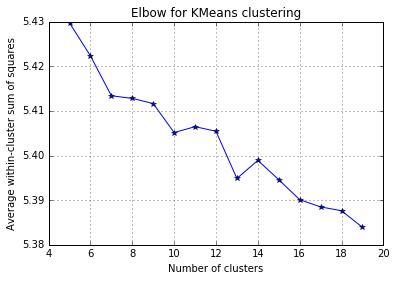

In [20]:
graphing(k_range, 'AWSS', binary_data_metrics)

#### Tf-idf weighting

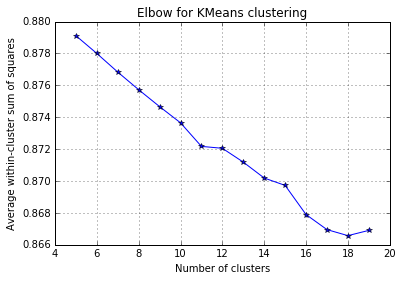

In [21]:
graphing(k_range, 'AWSS', tfidf_data_metrics)

#### Term frequency

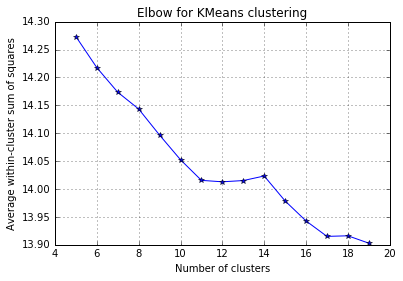

In [22]:
graphing(k_range, 'AWSS', tf_data_metrics)

### Variance Explained

#### Binary weighting

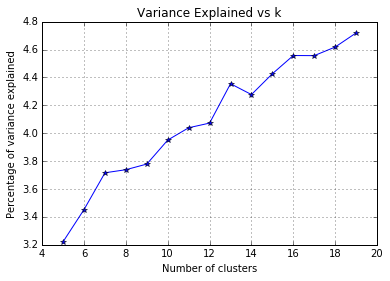

In [23]:
graphing(k_range, 'RSQ', binary_data_metrics)

#### Tf-idf weighting

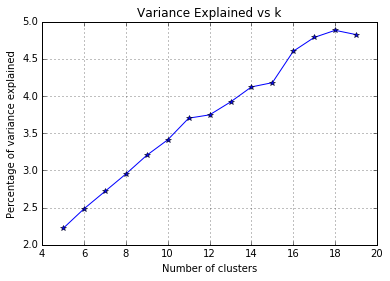

In [24]:
graphing(k_range, 'RSQ', tfidf_data_metrics)

#### Term frequency


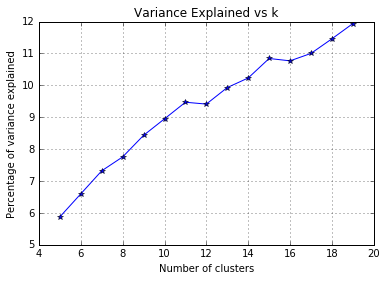

In [25]:
graphing(k_range, 'RSQ', tf_data_metrics)

### Silhouette score

#### Binary weighting

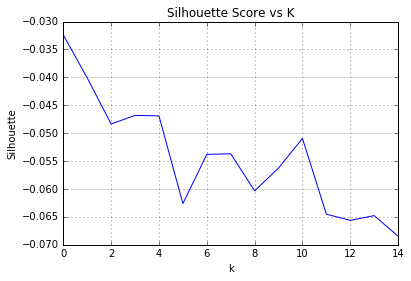

In [29]:
silhouetteGraph(binary_data_df, binary_data_clusters)

#### Tf-idf weighting

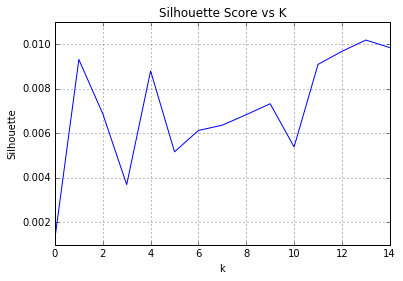

In [30]:
silhouetteGraph(tfidf_data_df, tfidf_data_clusters)

#### Term frequency

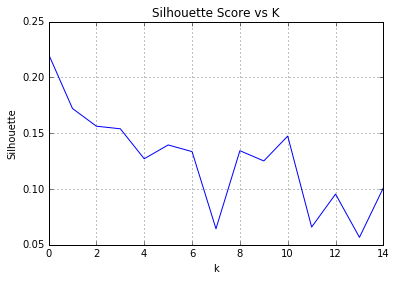

In [31]:
silhouetteGraph(tf_data_df, tf_data_clusters)

### Silhouette Score Analysis

#### Binary weighting

In [ ]:
# choose the cluster based on silhouette score plot above
# for binary weighted data, we choose cluster with k=7 <----should rerun since input data updated.
range_n = [7]
silhouetteAnalysis(binary_data_np, range_n)

#### Tf-idf weighting

In [ ]:
# choose the cluster based on silhouette score plot above
# for tf-idf weighted data, we choose cluster with k=2,9,11,14
range_n = [7]
silhouetteAnalysis(tfidf_data_np, range_n)

#### Term frequency

In [ ]:
# choose the cluster based on silhouette score plot above
# for term frequency data, we choose cluster with k=2,4,6,11
range_n = [7]
silhouetteAnalysis(tf_data_np, range_n)

In [ ]:
from scipy.cluster.vq import kmeans,vq,kmeans2
centroids,label=kmeans2(binary_data_df,7)
binary_data_df['cluster']= label

In [ ]:
km4groupd=binary_data_df.groupby(binary_data_df['cluster'])
km4groupd.size()
km4groupd.describe()

Reference:

http://www.pybloggers.com/grouping-nba-players/

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py